## 05 Drawdown Depth and Duration

Total Return, Annual Return, Annual Volatility, and Sharpe Ratio are all useful performance indicators. 

Drawdown periods are stretches of time during which an investment declines from a peak to a trough before recovering. They are important performance indicators because they reveal the risk and volatility of a strategy, helping investors understand potential losses and recovery behavior.

In this notebook I want to show what drawdown periods are and define a function calculating their depth and duration.

Knowing **depth** and **duration** of **drawdown** periods is important for a simple reason. Suppose you buy an asset and its value decreases by 15%. You are loosing 15% of the money invested. If you want to recover your loss, your asset value needs to increase by about 18%. This performance is remarkable and may take quite a long time to be achieved. So you might be waiting for months or years before just recovering the money you lost.

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
plt.style.use('ggplot')

In [3]:
# importing the necessary function
from Utils import prices

#### 1. Following the price evolution over time of one asset.

<Axes: title={'center': 'Price evolution of an ETF'}, xlabel='Date', ylabel='Price'>

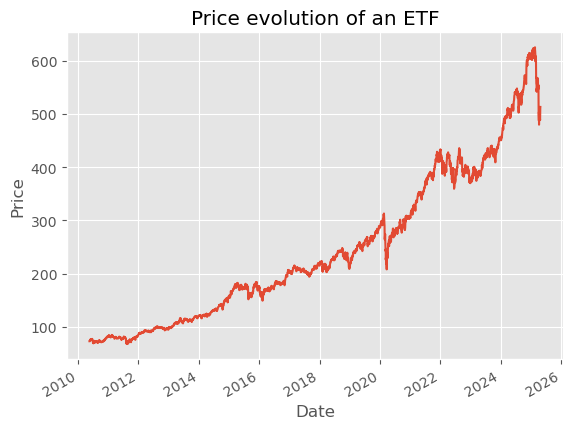

In [4]:
ticker = prices('CSSPX')
ticker.plot(title='Price evolution of an ETF', ylabel='Price')

I draw a blue line parallel to the horizontal axis at each price peak. If I had bought this asset at each price peak, I would have been underwater (= below the blue line) for a while before recovering all my money invested.

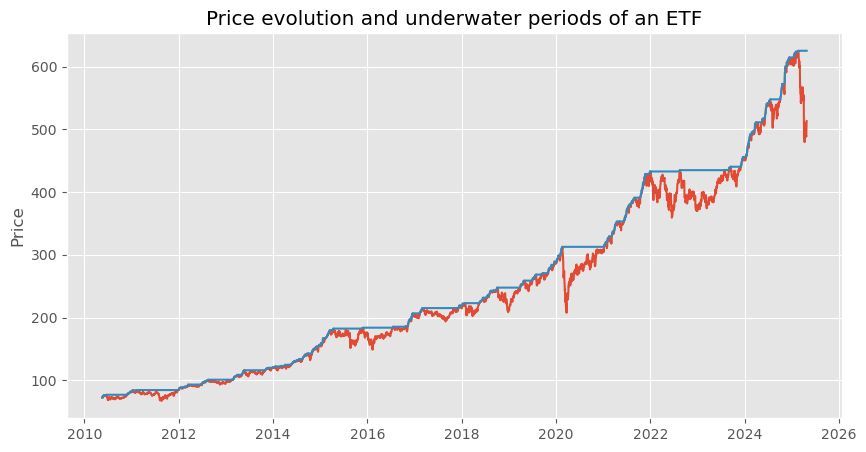

In [5]:
_= plt.figure(figsize=(10, 5))
_= plt.plot(ticker)
#_= plt.plot(np.maximum.accumulate(returns))
_= plt.plot(ticker.cummax())
_= plt.title('Price evolution and underwater periods of an ETF')
_= plt.ylabel('Price')
plt.show()

#### 2. Visualizing drawdown periods

I can calculate the % drop from each price peak and represent it with the red line. I can also calculate the maximum drop from the peak observed in a rolling window of lenght of 252 trading days (1 year) as shown by the blue line. This helps me visualizing depth and duration of various drawdown periods in the historical price series of the asset.

For example, I can see that this asset experienced a maximum drawdown of aboout 33% at beginning of 2020. I can also see that this drop was recovered by end of 2020 - beginning of 2021.

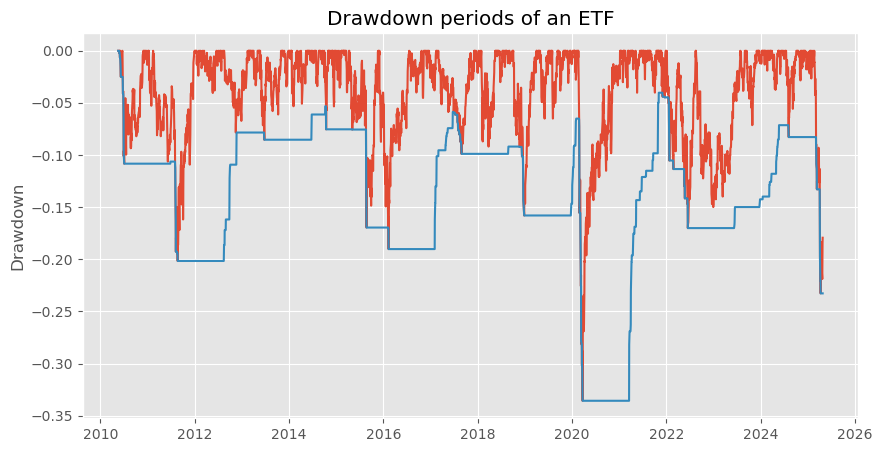

In [6]:
_= plt.figure(figsize=(10, 5))
_= plt.plot((ticker/ticker.cummax() - 1))
_= plt.plot((ticker/ticker.cummax() - 1).rolling(window=252, min_periods=1).min())
_= plt.title('Drawdown periods of an ETF')
_= plt.ylabel('Drawdown')
plt.show()

#### 3. Calculating depth and duration of drawdown periods

`uwater` is a mask to evaluate the days when the asset price `ticker` was below the price peak until that day, calculated by `ticker.cummax()`. `uwater` is a pd.Series of daily `True` and `False` depending on whether the asset price was below the peak.

`dd` is a pd.Series containing the daily drawdowns from the peaks over time.

In [7]:
uwater = (ticker - ticker.cummax()) < 0 # under water mask
dd = (ticker/ticker.cummax() - 1) # drawdowns

I want to create two lists: `start`, where I place the index of when a drawdown starts; `end`, where I place the index of whem a drawdown ends, that is when the next peak is reached.

A drawdown **starts** when at time $t$ I am underwater `AND` the day before (time $t-1$) I was not underwater. A drawdown **ends** when at time $t$ I am not underwater any more `AND` the day before (time $t-1$) I was still underwater.

In order to have the `start` and `end` lists of the same length, I impose - for the moment - that the last date of the price series is the end of the last drawdown period, even if I might be underwater. I'll fix this later in the code flow.

In [8]:
start = []
end = []
for t in range(1, len(uwater)):
  if uwater.iloc[t] and not uwater.iloc[t-1]:
    start.append(t)
  elif not uwater.iloc[t] and uwater.iloc[t-1]:
    end.append(t)
if len(start) > len(end):
  end.append(len(uwater)-1)

In [9]:
pd.to_datetime("today").strftime("%Y-%m-%d")

'2025-04-26'

In [10]:
# checking that both start and end lists have the same length
len(start), len(end)

(216, 216)

Now I create other two lists. `dd_peaks`, where I put the max % drawdown between the `start` and the `end` of one drawdown period. `max_dd`, where I put the day (`idxmin`), when the max % drawdown happened in one drawdown period.

In [11]:
dd_peaks = []
max_dd = []
for start_dd, end_dd in zip(start, end):
  dd_peaks.append(dd.iloc[start_dd:end_dd + 1].min())  # +1 to include the end index
  max_dd.append(dd.iloc[start_dd:end_dd + 1].idxmin())

In [12]:
# checking the first 5 days of max % drawdowns in the max_dd list
max_dd[:5]

[Timestamp('2010-05-28 00:00:00'),
 Timestamp('2010-06-02 00:00:00'),
 Timestamp('2010-06-09 00:00:00'),
 Timestamp('2010-07-05 00:00:00'),
 Timestamp('2010-12-03 00:00:00')]

I now have all the information on depth and duration of the drawdown periods, that I put in a DataFrame:

In [13]:
df = pd.DataFrame({'drawdown':dd_peaks,
                   'start': uwater.iloc[start].index,
                   'valley':max_dd,
                   'end': uwater.iloc[end].index })

In order to have the `start` and `end` lists of the same length, I imposed that the last date of the `end` list was the last price date in the price series. But this date may not necessarily be the end of the last drawdown period. So I check whether the end date of the last drawdown period is underwater:

In [14]:
uwater.loc[df['end'].iloc[-1]]

True

If the last date of the `end` list is underwater, I change it into `NaT` meaning that the last drawdown period has not ended yet:

In [15]:
if uwater.loc[df['end'].iloc[-1]]:
  df.iat[-1,3] = pd.NaT

Here the tail of my DataFrame with all the drawdown periods in my price time series. I can check whether the last drawdown period has not ended by reading `NaT` in the last row of the `end` column:

In [16]:
df.tail()

,drawdown,start,valley,end
211,-0.006886,2025-01-20,2025-01-20,2025-01-22
212,-0.026553,2025-01-24,2025-01-27,2025-01-31
213,-0.015279,2025-02-03,2025-02-05,2025-02-10
214,-0.010226,2025-02-11,2025-02-12,2025-02-19
215,-0.232641,2025-02-20,2025-04-09,NaT


#### 4. Function returning depth and duration of the worst 10 drawdown periods.

In [17]:
def drawdown_metrics(ticker: pd.Series) -> pd.DataFrame:
    """
    Calculates drawdown metrics for a given time series of portfolio or asset values.

    Identifies drawdown periods where the ticker value is below its cumulative max, 
    and returns the top 10 by maximum depth.

    Parameters:
    - ticker: pd.Series of daily portfolio values (indexed by date)

    Returns:
    - pd.DataFrame with columns:
        - 'drawdown': Maximum drawdown (as negative decimal)
        - 'start': Start date of drawdown
        - 'valley': Date of drawdown minimum
        - 'end': Recovery date (NaT if not recovered)
    """
    # Calculate drawdown as percent decline from peak
    cummax = ticker.cummax()
    dd = ticker / cummax - 1
    underwater = dd < 0

    # Identify start and end of drawdown periods
    start_idxs, end_idxs = [], []
    for i in range(1, len(underwater)):
        if underwater.iloc[i] and not underwater.iloc[i - 1]:
            start_idxs.append(i)
        elif not underwater.iloc[i] and underwater.iloc[i - 1]:
            end_idxs.append(i)

    # Handle case where drawdown hasn't recovered yet
    if len(start_idxs) > len(end_idxs):
        end_idxs.append(len(ticker) - 1)

    # Calculate drawdown stats
    data = []
    for start, end in zip(start_idxs, end_idxs):
        valley_idx = dd.iloc[start:end + 1].idxmin()
        drawdown = dd.loc[valley_idx]
        data.append({
            'drawdown': drawdown,
            'start': ticker.index[start],
            'valley': valley_idx,
            'end': ticker.index[end] if not underwater.iloc[end] else pd.NaT
        })

    # Return top 10 deepest drawdowns
    df = pd.DataFrame(data)
    df = df.sort_values('drawdown').head(10).reset_index(drop=True)
    return df

I can test my function and show the 10 worst drawdown periods of this ETF:

In [18]:
drawdowns = drawdown_metrics(ticker)
drawdowns

,drawdown,start,valley,end
0,-0.335635,2020-02-20,2020-03-23,2021-01-08
1,-0.232641,2025-02-20,2025-04-09,NaT
2,-0.201559,2011-02-15,2011-08-23,2012-01-02
3,-0.190166,2015-12-03,2016-02-11,2016-07-19
4,-0.170035,2022-01-03,2022-06-16,2022-08-16
5,-0.169515,2015-04-14,2015-08-24,2015-11-23
6,-0.157939,2018-10-04,2018-12-27,2019-04-01
7,-0.149862,2022-08-19,2022-12-30,2023-07-27
8,-0.108262,2010-06-22,2010-07-05,2010-11-30
9,-0.098848,2017-03-03,2017-08-29,2017-12-04


With the metrics returned by the function `drawdown_metrics()`, I can calculate and add the columns `duration`, `recovery_time`, and `total_length` to the DataFrame to have all the necessary information on the 10 worst drawdown periods.

In [19]:
drawdowns['duration'] = drawdowns['valley'] - drawdowns['start']
drawdowns['recovery_time'] = drawdowns['end'] - drawdowns['valley']
drawdowns['total_lenght'] = drawdowns['end'] - drawdowns['start']
drawdowns

,drawdown,start,valley,end,duration,recovery_time,total_lenght
0,-0.335635,2020-02-20,2020-03-23,2021-01-08,32 days,291 days,323 days
1,-0.232641,2025-02-20,2025-04-09,NaT,48 days,NaT,NaT
2,-0.201559,2011-02-15,2011-08-23,2012-01-02,189 days,132 days,321 days
3,-0.190166,2015-12-03,2016-02-11,2016-07-19,70 days,159 days,229 days
4,-0.170035,2022-01-03,2022-06-16,2022-08-16,164 days,61 days,225 days
5,-0.169515,2015-04-14,2015-08-24,2015-11-23,132 days,91 days,223 days
6,-0.157939,2018-10-04,2018-12-27,2019-04-01,84 days,95 days,179 days
7,-0.149862,2022-08-19,2022-12-30,2023-07-27,133 days,209 days,342 days
8,-0.108262,2010-06-22,2010-07-05,2010-11-30,13 days,148 days,161 days
9,-0.098848,2017-03-03,2017-08-29,2017-12-04,179 days,97 days,276 days


### Summary

In this chapter we have seen what drawdown periods are and why their metrics are important when testing a portfolio strategy. We have also defined the function `drawdown_metrics()`, that can be re-used to test any portfolio strategy.

In the next chapter I want to come back on backtesting strategies and take into consideration additional real life aspects.